## 라이브러리 로딩

In [1]:
%load_ext lab_black
%cd ..

/mnt/h/hev/motion-keypoint


In [2]:
import argparse, random
import multiprocessing
import json
import math
import sys
from dataclasses import dataclass
from pathlib import Path
from pprint import pformat

import cv2
import imageio
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from easydict import EasyDict
from PIL import Image
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

import networks
import options
import utils
from datasets import get_pose_datasets, TestKeypointDataset, KeypointDataset
from losses import AWing, JointMSELoss, KeypointBCELoss, KeypointLoss, KeypointRMSE, SigmoidMAE, SigmoidKLDivLoss
from importlib import import_module
from error_list import error_list

import pandas as pd

## 모델 로딩

In [3]:
with open("config/hrnet-w48-train-ce-512x512.yaml", "r") as f:
    C = EasyDict(yaml.load(f, yaml.FullLoader))

    if C.dataset.num_cpus < 0:
        C.dataset.num_cpus = multiprocessing.cpu_count()

    C.result_dir = Path(C.result_dir)
    C.dataset.train_dir = Path(C.dataset.train_dir)
    utils.seed_everything(C.seed, deterministic=False)

In [4]:
main = import_module("main-hrnet-train")

In [5]:
trainer = main.PoseTrainer(C, 1, "results/hrnet-train2/HRNet-W48-ce-512x512-plus_augment-maw-rr2.0-ReduceLROnPlateau_1.pth")

Load pretrained results/hrnet-train2/HRNet-W48-ce-512x512-plus_augment-maw-rr2.0-ReduceLROnPlateau_1.pth


In [6]:
model = trainer.pose_model
model.eval()
torch.set_grad_enabled(False)

## Train 이미지 보여주기

In [7]:
total_imgs = np.array(sorted(list(Path(C.dataset.train_dir).glob("*.jpg"))))
df = pd.read_csv(C.dataset.target_file)
total_keypoints = df.to_numpy()[:, 1:].astype(np.float32)
total_keypoints = np.stack([total_keypoints[:, 0::2], total_keypoints[:, 1::2]], axis=2)

# 오류가 있는 데이터는 학습에서 제외
total_imgs_, total_keypoints_ = [], []
for i in range(len(total_imgs)):
    if i not in error_list:
        total_imgs_.append(total_imgs[i])
        total_keypoints_.append(total_keypoints[i])
total_imgs = np.array(total_imgs_)
total_keypoints = np.array(total_keypoints_)

kf = KFold(n_splits=5, shuffle=True, random_state=C.seed)
indices = list(kf.split(total_imgs))
train_idx, valid_idx = indices[0]

train_imgs = total_imgs[train_idx]
train_keypoints = total_keypoints[train_idx]
valid_imgs = total_imgs[valid_idx]
valid_keypoints = total_keypoints[valid_idx]

In [8]:
ds_train = KeypointDataset(C, train_imgs, train_keypoints, augmentation=True)
ds_valid = KeypointDataset(C, valid_imgs, valid_keypoints, augmentation=False)

In [9]:
def denormalize(x):
    mean = torch.tensor(C.dataset.mean)
    std = torch.tensor(C.dataset.std)
    return utils.denormalize(x, mean, std)

(<matplotlib.image.AxesImage at 0x7f568dc56f90>, tensor([0.8982, 0.8797]))

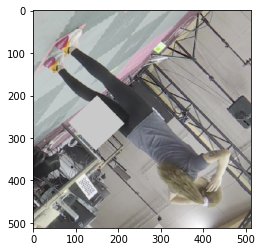

In [10]:
file, img, thmap, ratio, offset = ds_train[0]
img_np = denormalize(img).mul(255).type(torch.uint8).permute(1, 2, 0).numpy()
plt.imshow(img_np), ratio

cutout 어느정도 할지 고민

### Valdiation

In [11]:
file, img, thmap, ratio, offset = ds_valid[0]

In [12]:
img_np = denormalize(img).mul(255).type(torch.uint8).permute(1, 2, 0).numpy()

(<matplotlib.image.AxesImage at 0x7f568dbf3ed0>, tensor([1.7840, 0.8904]))

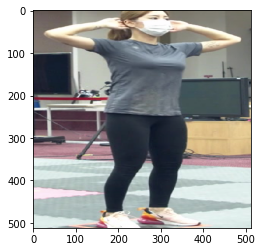

In [13]:
plt.imshow(img_np), ratio

In [14]:
phmap = model(img.cuda().unsqueeze(0))[0].cpu()

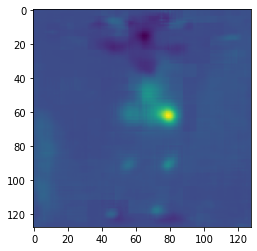

In [15]:
plt.imshow(phmap[11])

In [16]:
pkey = utils.heatmaps2keypoints(phmap)
pkey = pkey * 4 / ratio.view(1, 2) + offset.view(1, 2)

In [17]:
pkey

tensor([[1046.4062,  380.9531],
        [1050.8906,  371.9688],
        [1035.1953,  371.9688],
        [1021.7422,  389.9375],
        [1003.8047,  385.4453],
        [1062.1016,  457.3203],
        [ 981.3828,  448.3359],
        [1136.0938,  430.3672],
        [ 900.6641,  412.3984],
        [1080.0391,  394.4297],
        [ 963.4453,  389.9375],
        [1053.1328,  632.5156],
        [ 999.3203,  628.0234],
        [1053.1328,  762.7891],
        [1001.5625,  762.7891],
        [1039.6797,  879.5859],
        [ 979.1406,  888.5703],
        [1021.7422,  421.3828],
        [1062.1016,  394.4297],
        [ 983.6250,  385.4453],
        [1021.7422,  506.7344],
        [1026.2266,  574.1172],
        [1055.3750,  906.5391],
        [ 990.3516,  906.5391]])

In [18]:
img_np = imageio.imread(file)

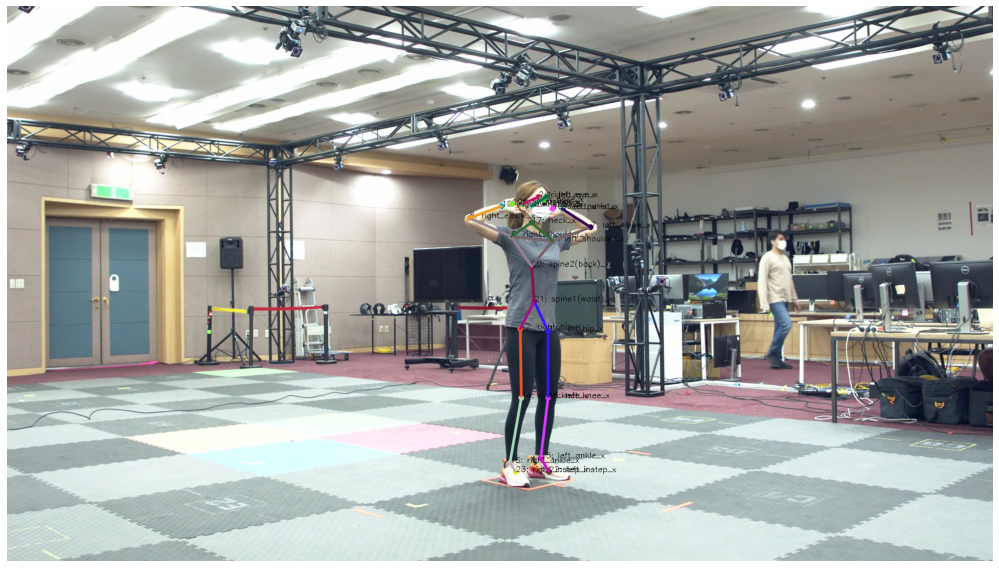

In [19]:
utils.draw_keypoints_show(img_np, pkey)

## 모든 valid 파일에 대해 적용

In [72]:
outdir = Path("results/hrnet-train2/example/HRNet-W48-ce-512x512-plus_augment-maw-rr2.0-ReduceLROnPlateau/valid_1")
outdir.mkdir(parents=True, exist_ok=True)

In [73]:
with tqdm(total=len(ds_valid), ncols=100, file=sys.stdout) as t:
    for i in range(len(ds_valid)):
        file, img, thmap, ratio, offset = ds_valid[i]
        phmap = model(img.cuda().unsqueeze(0))[0].cpu()
        pkey = utils.heatmaps2keypoints(phmap)
        pkey = pkey * 4 / ratio.view(1, 2) + offset.view(1, 2)
        img_np = imageio.imread(file)
        img_out = utils.draw_keypoints(img_np, pkey)
        imageio.imwrite(outdir / f"{i:04d}-{Path(file).name}", img_out)

        t.update()

100%|█████████████████████████████████████████████████████████████| 817/817 [02:24<00:00,  5.65it/s]


## 잘 안된거 heatmap 확인 / 후처리 논의

후처리로 어떻게 원만하게 해결볼 방법은 없을지?

In [34]:
df = pd.read_csv("data/ori/train_df.csv")

In [41]:
for i, col in enumerate(df.columns[1:]):
    print(i, col)

0 nose_x
1 nose_y
2 left_eye_x
3 left_eye_y
4 right_eye_x
5 right_eye_y
6 left_ear_x
7 left_ear_y
8 right_ear_x
9 right_ear_y
10 left_shoulder_x
11 left_shoulder_y
12 right_shoulder_x
13 right_shoulder_y
14 left_elbow_x
15 left_elbow_y
16 right_elbow_x
17 right_elbow_y
18 left_wrist_x
19 left_wrist_y
20 right_wrist_x
21 right_wrist_y
22 left_hip_x
23 left_hip_y
24 right_hip_x
25 right_hip_y
26 left_knee_x
27 left_knee_y
28 right_knee_x
29 right_knee_y
30 left_ankle_x
31 left_ankle_y
32 right_ankle_x
33 right_ankle_y
34 neck_x
35 neck_y
36 left_palm_x
37 left_palm_y
38 right_palm_x
39 right_palm_y
40 spine2(back)_x
41 spine2(back)_y
42 spine1(waist)_x
43 spine1(waist)_y
44 left_instep_x
45 left_instep_y
46 right_instep_x
47 right_instep_y


In [20]:
file, img, thmap, ratio, offset = ds_valid[510]

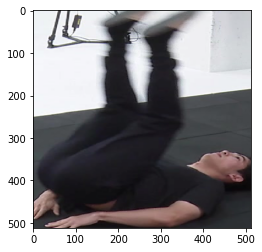

In [21]:
img_np = denormalize(img).mul(255).type(torch.uint8).permute(1, 2, 0).numpy()
plt.imshow(img_np)

In [66]:
phmap = model(img.unsqueeze(0).cuda())[0].cpu()

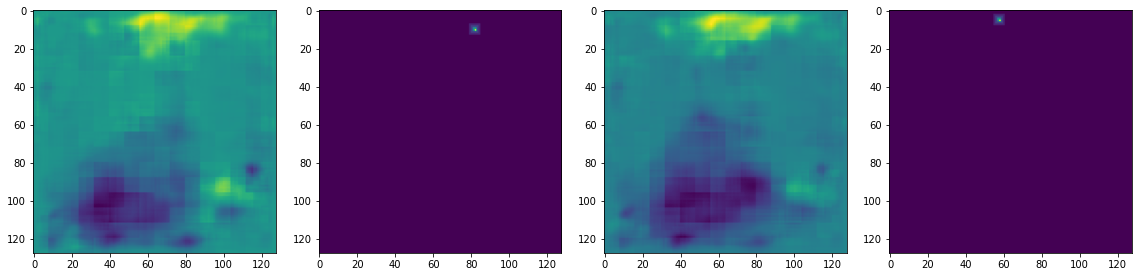

In [67]:
utils.imshows(phmap[22], thmap[22], phmap[23], thmap[23], figsize=(16, 4))

### Rot90

In [68]:
phmap = model(img.rot90(1, (1, 2)).unsqueeze(0).cuda())[0].cpu().rot90(3, (1, 2))

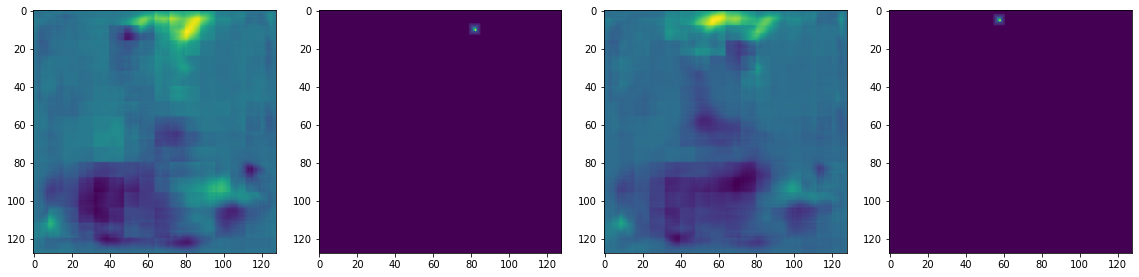

In [69]:
utils.imshows(phmap[22], thmap[22], phmap[23], thmap[23], figsize=(16, 4))

### Rot180

In [70]:
phmap = model(img.rot90(2, (1, 2)).unsqueeze(0).cuda())[0].cpu().rot90(2, (1, 2))

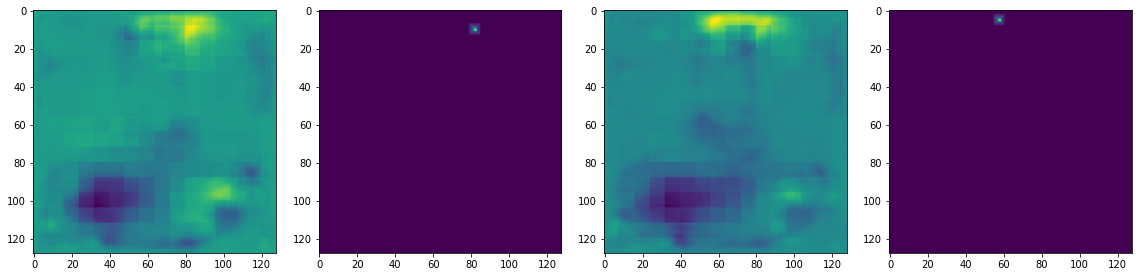

In [71]:
utils.imshows(phmap[22], thmap[22], phmap[23], thmap[23], figsize=(16, 4))

### Rot270

In [72]:
phmap = model(img.rot90(3, (1, 2)).unsqueeze(0).cuda())[0].cpu().rot90(1, (1, 2))

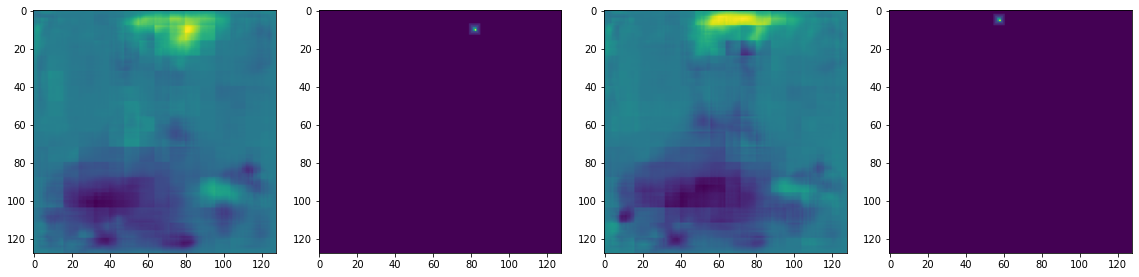

In [73]:
utils.imshows(phmap[22], thmap[22], phmap[23], thmap[23], figsize=(16, 4))

### Extend

In [74]:
img_ = F.interpolate(img.unsqueeze(0), (768, 768))
phmap = model(img_.cuda())
phmap = F.interpolate(phmap, (512, 512))[0].cpu()

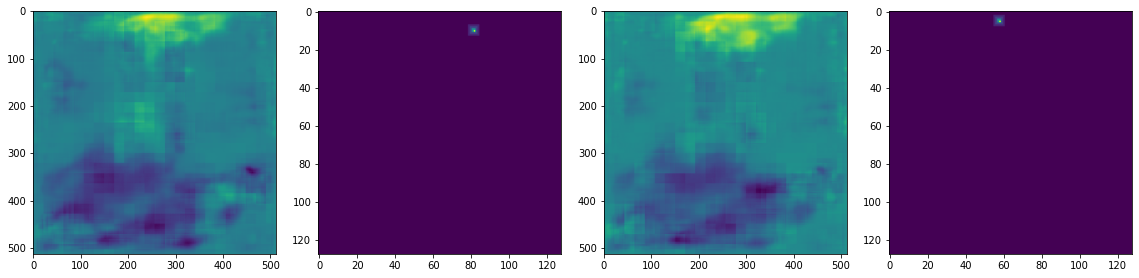

In [75]:
utils.imshows(phmap[22], thmap[22], phmap[23], thmap[23], figsize=(16, 4))

### Shrink

예상외로, 확대한거보다 축소했을 때 잘됐음??

In [76]:
img_ = F.interpolate(img.unsqueeze(0), (256, 256))
phmap = model(img_.cuda())
phmap = F.interpolate(phmap, (512, 512))[0].cpu()

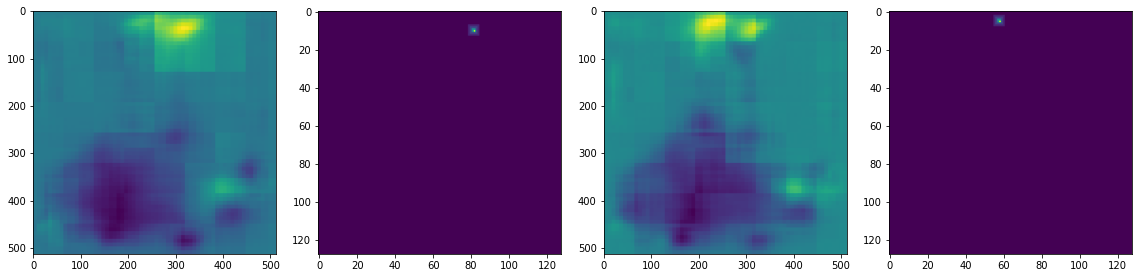

In [77]:
utils.imshows(phmap[22], thmap[22], phmap[23], thmap[23], figsize=(16, 4))

### Horizontal Flip

In [78]:
img_ = torch.flip(img.unsqueeze(0), (3,))
phmap = model(img_.cuda())
phmap = torch.flip(phmap, (3,))[0].cpu()

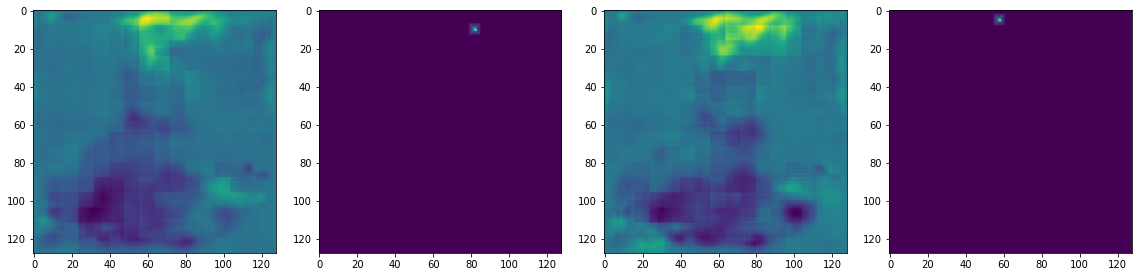

In [79]:
utils.imshows(phmap[22], thmap[22], phmap[23], thmap[23], figsize=(16, 4))

### Vertical Flip

In [80]:
img_ = torch.flip(img.unsqueeze(0), (2,))
phmap = model(img_.cuda())
phmap = torch.flip(phmap, (2,))[0].cpu()

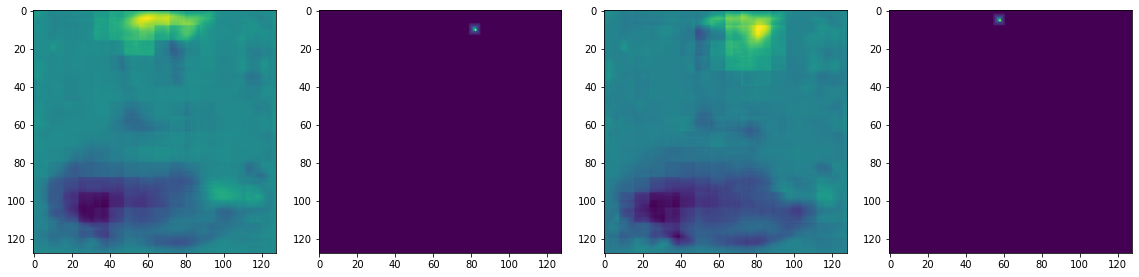

In [81]:
utils.imshows(phmap[22], thmap[22], phmap[23], thmap[23], figsize=(16, 4))

In [23]:
files = sorted(list(Path("results/effdet-train/example/efficientdet-d7_multi5_flip_median_test_imgs/").glob("*.jpg")))
with open("results/effdet-train/example/efficientdet-d7_multi5_flip_median_test_imgs/info.json", "r") as f:
    info = json.load(f)

In [21]:
open("results/effdet-train/example/efficientdet-d7_multi5_flip_median_test_imgs/info.json", "r")

<_io.TextIOWrapper name='results/effdet-train/example/efficientdet-d7_multi5_flip_median_test_imgs/info.json' mode='r' encoding='UTF-8'>

In [25]:
model = trainer.pose_model

In [ ]:
model

In [9]:
x = torch.tensor(im, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

In [11]:
x.shape

torch.Size([1, 3, 469, 540])

In [14]:
x2 = F.interpolate(x, (768, 576))

In [16]:
out = hrnet(x2)

In [17]:
out.shape

torch.Size([1, 17, 192, 144])